In [1]:
import random
from joblib import  load
import numpy as np
import numpy.ma as ma  

import pandas as pd

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

import random
from collections import defaultdict
from typing import Tuple, Dict, List
import torch
# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
from torch import optim, nn, utils, transpose, device, cuda, save, isinf, backends, manual_seed, LongTensor, tensor, long
DEVICE = device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
from typing import Optional, Literal, List, Tuple, Union
from torch.optim import Adam
from pathlib import Path
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import torch
import os
from torch import optim, nn, logsumexp, cuda, save, backends, manual_seed, LongTensor, zeros_like, ones_like, tensor, cat
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader, random_split
torch.autograd.set_detect_anomaly(True)
from model.model import EncoderRNN, DecoderRNN
import numpy as np
from torch.optim import Adam
import itertools
import random
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import ar_vae_metrics as m
import monitoring as mn
import regularization as r
sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [2]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [3]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())

def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)

def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())


In [4]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

# Unconstrained

In [5]:
sequences_arvae = pd.read_csv('./sequences.csv', header=None)
sequences_arvae[0] = sequences_arvae[0].str.strip().str.rstrip("0")
df_arvae = sequences_arvae[~sequences_arvae[0].str.contains("0")]
generated_arvae = df_arvae[0].tolist()

sequences_iwae = pd.read_csv('./sequences_iwae.csv', header=None)
sequences_iwae[0] = sequences_iwae[0].str.strip().str.rstrip("0")
df_iwae = sequences_iwae[~sequences_iwae[0].str.contains("0")]
generated_iwae = df_iwae[0].tolist()

uniprot_df = pd.read_csv('./data/Uniprot_0_25_train.csv')
uniprot_peptides = uniprot_df['Sequence'].tolist()

In [6]:
#Get random peptides
random_gen = modlamp.sequences.Random(50000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [7]:
class AMPDataManager:

    def __init__(
            self,
            positive_filepath: str,
            negative_filepath: str,
            min_len: int,
            max_len: int,
    ):
        self.positive_data = pd.read_csv(positive_filepath)
        self.negative_data = pd.read_csv(negative_filepath)

        self.min_len = min_len
        self.max_len = max_len

    def _filter_by_length(self, df: pd.DataFrame) -> pd.DataFrame:
        mask = (df['Sequence'].str.len() >= self.min_len) & (df['Sequence'].str.len() <= self.max_len)
        return df.loc[mask]

    def _filter_data(self):
        return self._filter_by_length(self.positive_data), self.negative_data

    @staticmethod
    def _get_probs(peptide_lengths: List[int]) -> Dict[int, float]:
        probs = defaultdict(lambda: 1)
        for length in peptide_lengths:
            probs[length] += 1
        return {k: round(v / len(peptide_lengths), 4) for k, v in probs.items()}

    @staticmethod
    def _draw_subsequences(df, new_lengths):
        # random.seed(44)
        new_lengths.sort(reverse=True)
        df = df.sort_values(by="Sequence length", ascending=False)

        d = []
        for row, new_length in zip(df.itertuples(), new_lengths):
            seq = row[2]
            curr_length = row[3]
            if new_length > curr_length:
                new_seq = seq
            elif new_length == curr_length:
                new_seq = seq
            else:
                begin = random.randrange(0, int(curr_length) - new_length)
                new_seq = seq[begin:begin + new_length]
            d.append(
                {
                    'Name': row[1],
                    'Sequence': new_seq,
                }
            )
        new_df = pd.DataFrame(d)
        return new_df

    def _equalize_data(self, positive_data: pd.DataFrame, negative_data: pd.DataFrame, balanced_classes: bool = True):
        positive_seq = positive_data['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = negative_data['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]
        negative_data.loc[:, "Sequence length"] = negative_lengths

        probs = self._get_probs(positive_lengths)
        k = len(positive_lengths) if balanced_classes else len(negative_lengths)

        new_negative_lengths = random.choices(list(probs.keys()), probs.values(), k=k)
        negative_data_distributed = self._draw_subsequences(self.negative_data, new_negative_lengths)
        return positive_data, negative_data_distributed

    def plot_distributions(self, equalize: bool = True):
        if equalize:
            pos_dataset, neg_dataset = self.get_data()
        else:
            pos_dataset, neg_dataset = self.positive_data, self.negative_data
        sns.set(color_codes=True)
        # TODO: figure out where this functionality should be. Goal is to plot distribution before and after baladancing
        positive_seq = pos_dataset['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = neg_dataset['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]

        fig, (ax2, ax3) = plt.subplots(figsize=(12, 6), ncols=2)
        sns.distplot(positive_lengths, ax=ax2)
        sns.distplot(negative_lengths, ax=ax3)
        ax2.set_title("Positive")
        ax3.set_title("Negative")

        plt.show()

    def _join_datasets(self, pos_dataset: pd.DataFrame, neg_dataset: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        pos_dataset.loc[:, 'Label'] = 1
        neg_dataset.loc[:, 'Label'] = 0
        merged = pd.concat([pos_dataset, neg_dataset])
        x = np.asarray(merged['Sequence'].tolist())
        y = np.asarray(merged['Label'].tolist())
        return x, y

    def get_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self._filter_data()
        return self._equalize_data(pos_dataset, neg_dataset, balanced_classes=balanced)

    def get_merged_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self.get_data(balanced=balanced)
        return self._join_datasets(pos_dataset, neg_dataset)

In [8]:
def set_seed(seed: int = 42) -> None:
    """
    Source:
    https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
    """
    np.random.seed(seed)
    random.seed(seed)
    manual_seed(seed)
    cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    backends.cudnn.deterministic = True
    backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    # logger.info(f"Random seed set to {seed}")
    return None
set_seed()

data_manager = AMPDataManager(
    './data/unlabelled_positive.csv',
    './data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
baseline_peptides = amp_x.tolist()
df = pd.DataFrame({
    'Sequence': amp_x,
    'Label': amp_y
})
nonamp_peptides = df[df['Label'] == 0]['Sequence'].to_list()
amp_peptides = df[df['Label'] == 1]['Sequence'].to_list()

C:\Users\olagw\AppData\Local\Temp\ipykernel_2576\3809696541.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_dataset.loc[:, 'Label'] = 1


In [9]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []


    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [10]:
datasets = [
    'Uniprot',
    'AMPs',
    'Non AMPs'
]

peptides = [
    uniprot_peptides,
    amp_peptides,
    nonamp_peptides
]

In [11]:
physchem = calculate_physchem(peptides, datasets)

In [94]:
custom = [['GWLNKIIKKAWRKFHEIFSK', 'GWLWKIIKKAWRKFHKIFSK', 'GWLKKIIKKAWRKFHKIFSK']]
calculate_physchem(custom, [['Custom']])

,dataset,length,charge,pi,aromacity,hydrophobicity,hm
0,[Custom],20,6.095,11.218750,0.20,-0.0840,0.655211
1,[Custom],20,8.093,11.861328,0.25,-0.0425,0.702357
2,[Custom],20,9.093,11.903809,0.20,-0.1580,0.686947


In [13]:
physchem_temp = physchem.loc[:, ['pi', 'charge', 'hm', 'aromacity', 'dataset']]
physchem_quantiles = physchem_temp.groupby('dataset').quantile([0.25, 0.5, 0.75])
physchem_quantiles.to_csv('Supp_SourceData_FigureS1_quantiles.csv')

## Boxplots

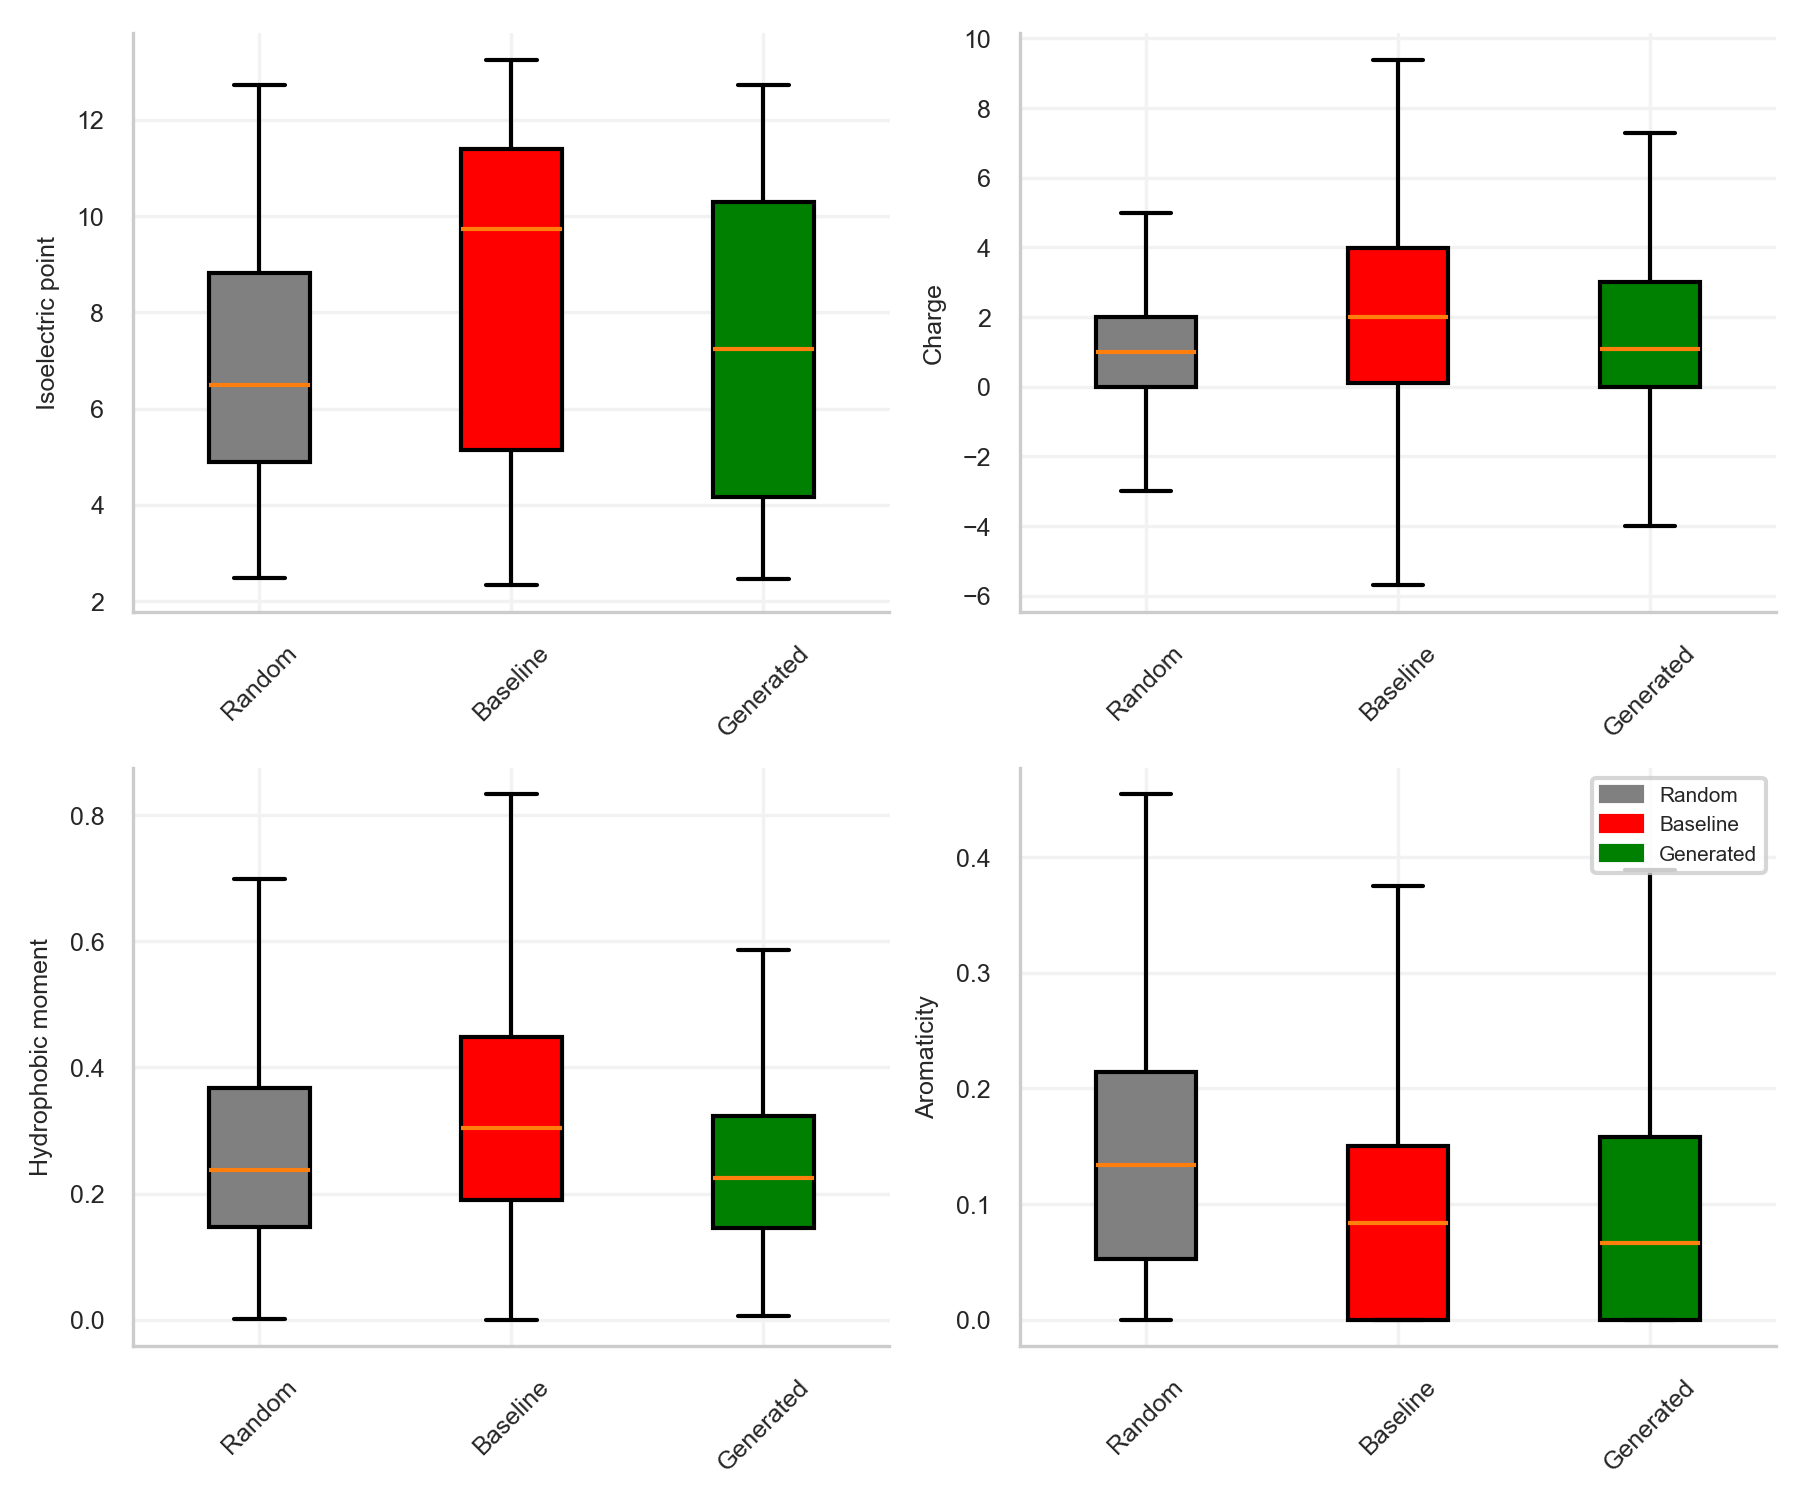

In [64]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.boxplot(
        filtered_data,
        showfliers=False,
        patch_artist=True,
        widths=0.4
    )
    
    # Apply colors
    for patch, color in zip(parts['boxes'], ['grey', 'red', 'green']):
        patch.set_facecolor(color)
    
    # Set labels
    ax.set_xticks([1, 2, 3])  
    ax.set_xticklabels(['Random', 'Baseline', 'Generated'], rotation=45)
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    
        mpatches.Patch(color='red', label='Baseline'),
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

for prop, label, ax in zip(properties, labels, axes):
    # Extract only "Random" and "Generated" data
    sample_amps = physchem.loc[physchem['dataset'] == 'AMPs', prop]
    sample_nonamps = physchem.loc[physchem['dataset'] == 'Non AMPs', prop]

    # U Manna-Whitneya test
    # alternative='two-sided' testuje, czy rozkłady są różne (niezależnie czy A > B czy B > A)
    # Możesz użyć 'less' lub 'greater' jeśli masz konkretną hipotezę kierunkową
    statistic, p_value = mannwhitneyu(sample_amps, sample_nonamps, alternative='two-sided')
    alpha = 0.05
    print(f"\nAtrybut: {prop}")
    print(f"Statystyka U: {statistic:.4f}")
    print(f"Wartość p: {p_value:.4f}")

    if p_value < alpha:
        print(f"-> Wynik: Istotna statystycznie różnica (p < {alpha}). Atrybut '{prop}' jest istotnie rozróżnialny.")
    else:
        print(f"-> Wynik: Brak istotnej statystycznie różnicy (p >= {alpha}). Atrybut '{prop}' nie jest istotnie rozróżnialny.")



Atrybut: charge
Statystyka U: 101985186.0000
Wartość p: 0.0000
-> Wynik: Istotna statystycznie różnica (p < 0.05). Atrybut 'charge' jest istotnie rozróżnialny.

Atrybut: hm
Statystyka U: 81716040.5000
Wartość p: 0.0000
-> Wynik: Istotna statystycznie różnica (p < 0.05). Atrybut 'hm' jest istotnie rozróżnialny.

Atrybut: length
Statystyka U: 61506840.0000
Wartość p: 0.3533
-> Wynik: Brak istotnej statystycznie różnicy (p >= 0.05). Atrybut 'length' nie jest istotnie rozróżnialny.


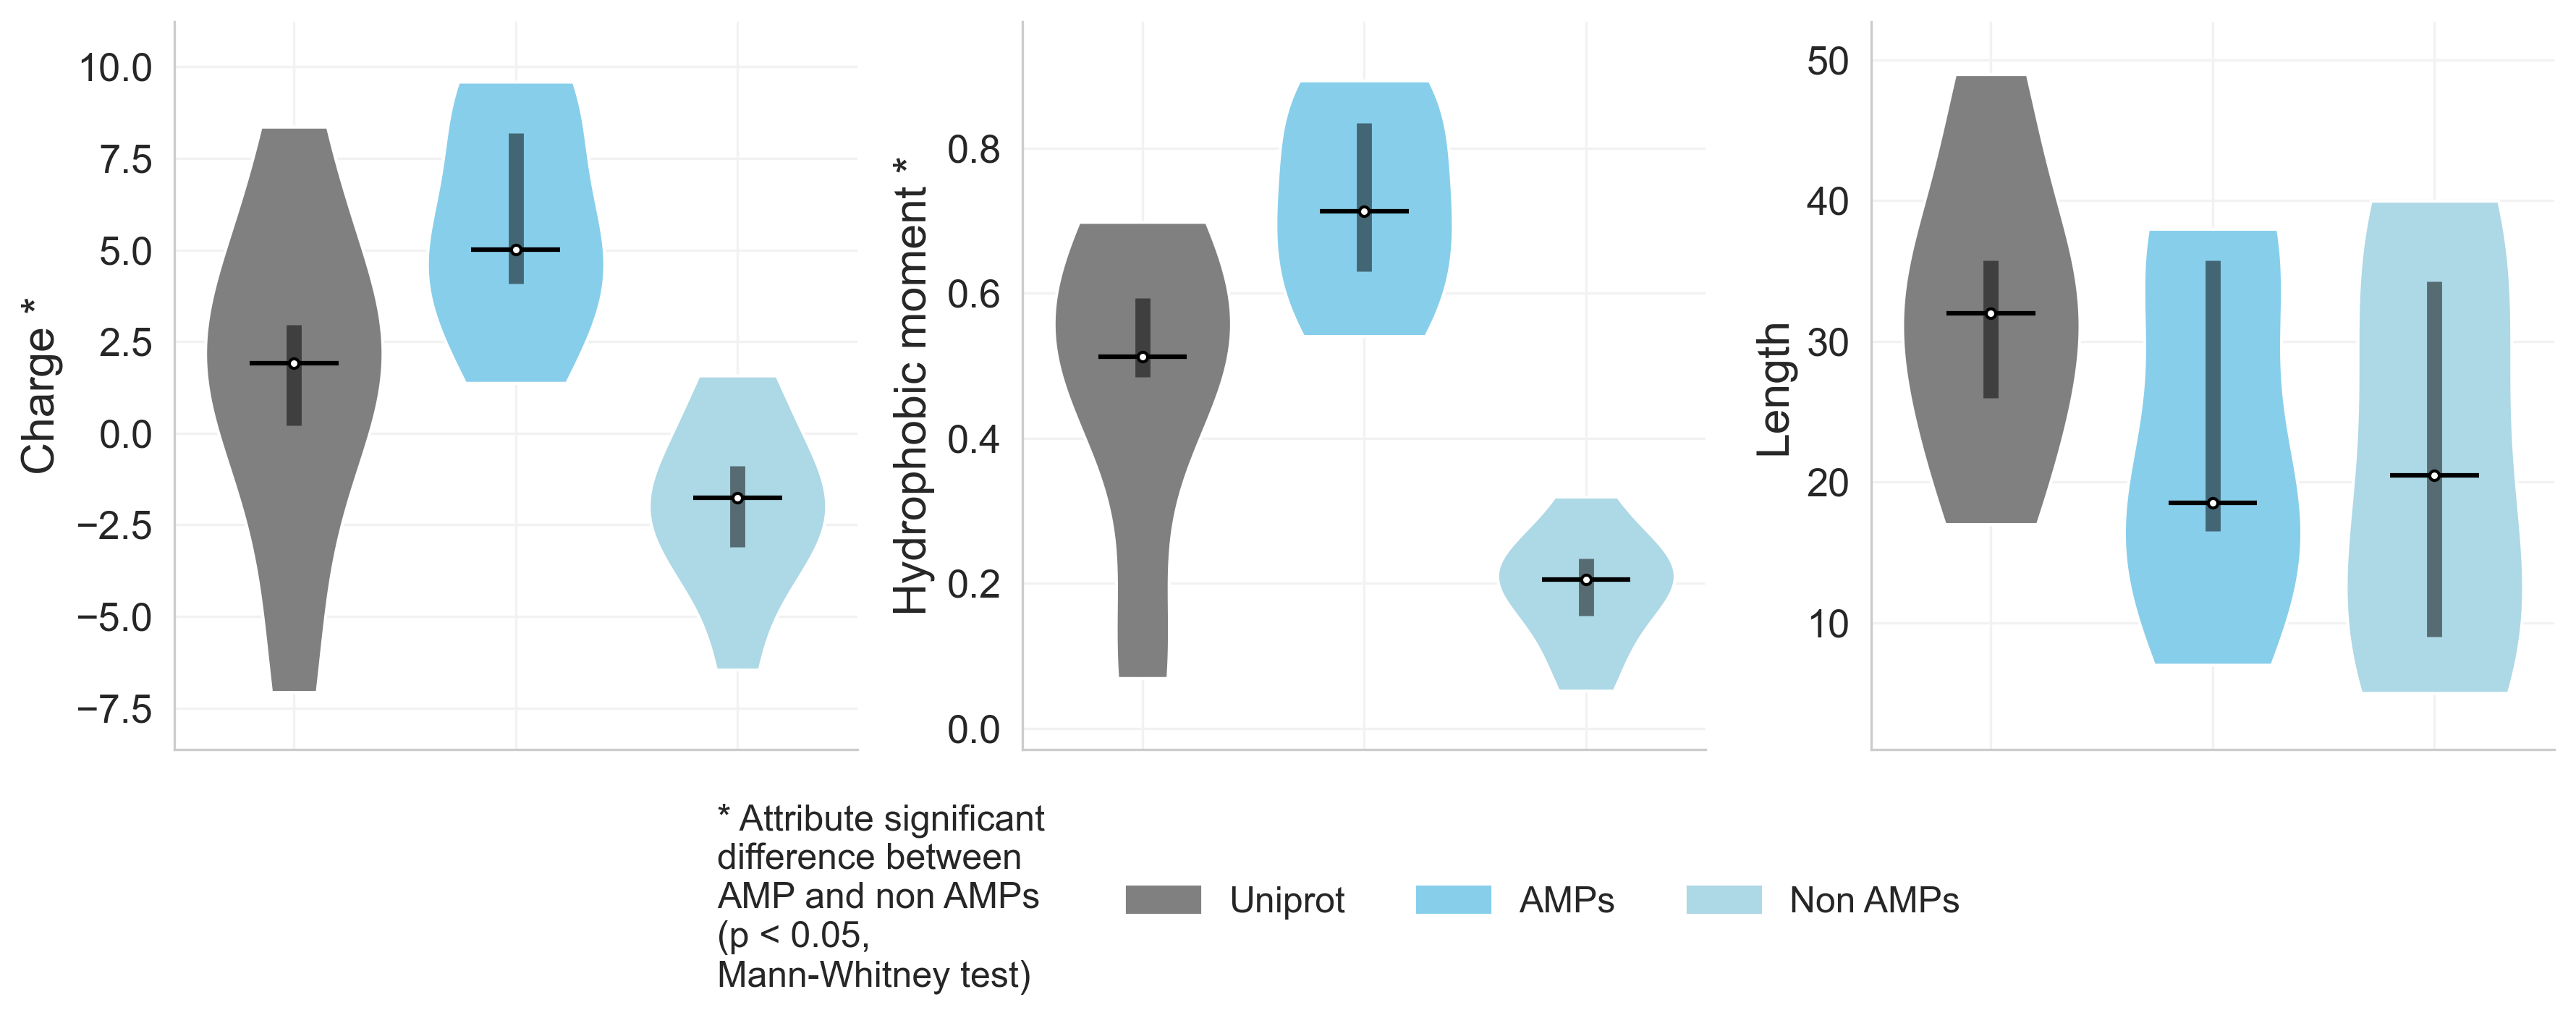

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# --- Your DataFrame simulation (assuming it exists) ---
data = {
    'dataset': ['Uniprot', 'AMPs', 'Non AMPs'] * 10,
    'charge': np.random.normal(0, 5, 30),
    'hm': np.random.normal(0.5, 0.2, 30),
    'length': np.random.randint(5, 50, 30)
}
physchem = pd.DataFrame(data)
physchem.loc[physchem['dataset'] == 'AMPs', 'charge'] = np.random.normal(5, 3, 10)
physchem.loc[physchem['dataset'] == 'Non AMPs', 'charge'] = np.random.normal(-2, 3, 10)
physchem.loc[physchem['dataset'] == 'AMPs', 'hm'] = np.random.normal(0.8, 0.1, 10)
physchem.loc[physchem['dataset'] == 'Non AMPs', 'hm'] = np.random.normal(0.2, 0.1, 10)


# --- Your plotting code with the legend modification ---

fig, _axes = plt.subplots(
    ncols=3, 
    nrows=1,
    figsize=(12, 4),
    dpi=300,
)
axes = [_axes[0], _axes[1], _axes[2]]
properties = ['charge', 'hm', 'length']
labels = ['Charge', 'Hydrophobic moment', 'Length']
medianprops = {'color': 'black', 'linewidth': 1.5}

selected_datasets = ['Uniprot', 'AMPs', 'Non AMPs']

for prop, label, ax in zip(properties, labels, axes):
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    parts = ax.violinplot(
        filtered_data,
        showmeans=False,
        showmedians=True,
        showextrema=False,
        widths=0.8,
        bw_method='silverman',
        points=100,
    )

    for patch, color in zip(parts['bodies'], ['grey', 'skyblue', 'lightblue']):
        patch.set_facecolor(color)
        patch.set_alpha(1)

    if 'cmedians' in parts:
        parts['cmedians'].set_color(medianprops.get('color', 'black'))
        parts['cmedians'].set_linewidth(medianprops.get('linewidth', 1.5))
        
    for i, dataset in enumerate(filtered_data):
        q1 = np.percentile(dataset, 25)
        q2 = np.percentile(dataset, 50)
        q3 = np.percentile(dataset, 75)
        
        x = i + 1

        ax.vlines(x, q1, q3, color='black', linewidth=5, alpha=0.5)
        ax.scatter(x, q2, facecolor='white', edgecolor='black', s=10, zorder=4)
        
        if label == 'Charge' or label == 'Hydrophobic moment':
            ax.set_ylabel(f"{label} *", fontsize=15)
        else:
            ax.set_ylabel(f"{label}", fontsize=15)
        
    all_values = np.concatenate(filtered_data)
    ymin = np.quantile(all_values, 0.005)
    ymax = np.quantile(all_values, 0.995)
    yrange = ymax - ymin
    padding = yrange * 0.1 if yrange > 0 else 1
    ax.set_ylim(ymin - padding, ymax + padding)
    ax.set_xticks(range(1, len(selected_datasets) + 1))
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.set_xticklabels([]) 
    ax.tick_params(axis='y', labelsize=13)

# Adjust layout to make room for the legend
# The 'pad' value might need fine-tuning
plt.tight_layout(pad=2.0)

# --- Legend Code: place it outside, at the bottom, and make it HORIZONTAL ---
fig.legend(
    handles=[
        mpatches.Patch(color='none', label='* Attribute significant \ndifference between \nAMP and non AMPs \n(p < 0.05, \nMann-Whitney test)'),
        mpatches.Patch(color='grey', label='Uniprot'), 
        mpatches.Patch(color='skyblue', label='AMPs'),
        mpatches.Patch(color='lightblue', label='Non AMPs'),
    ], 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2), # Adjust y value to position the legend lower
    ncol=4, # <--- Zmiana tutaj! Ustawiamy 4 kolumny.
    fontsize=12,
    frameon=False
)

# You can use subplots_adjust to manually fine-tune the bottom margin
fig.subplots_adjust(bottom=0.12)

# Save & Show Plot
fig.savefig("./physchem_amps.png")
plt.show()

## Distributions

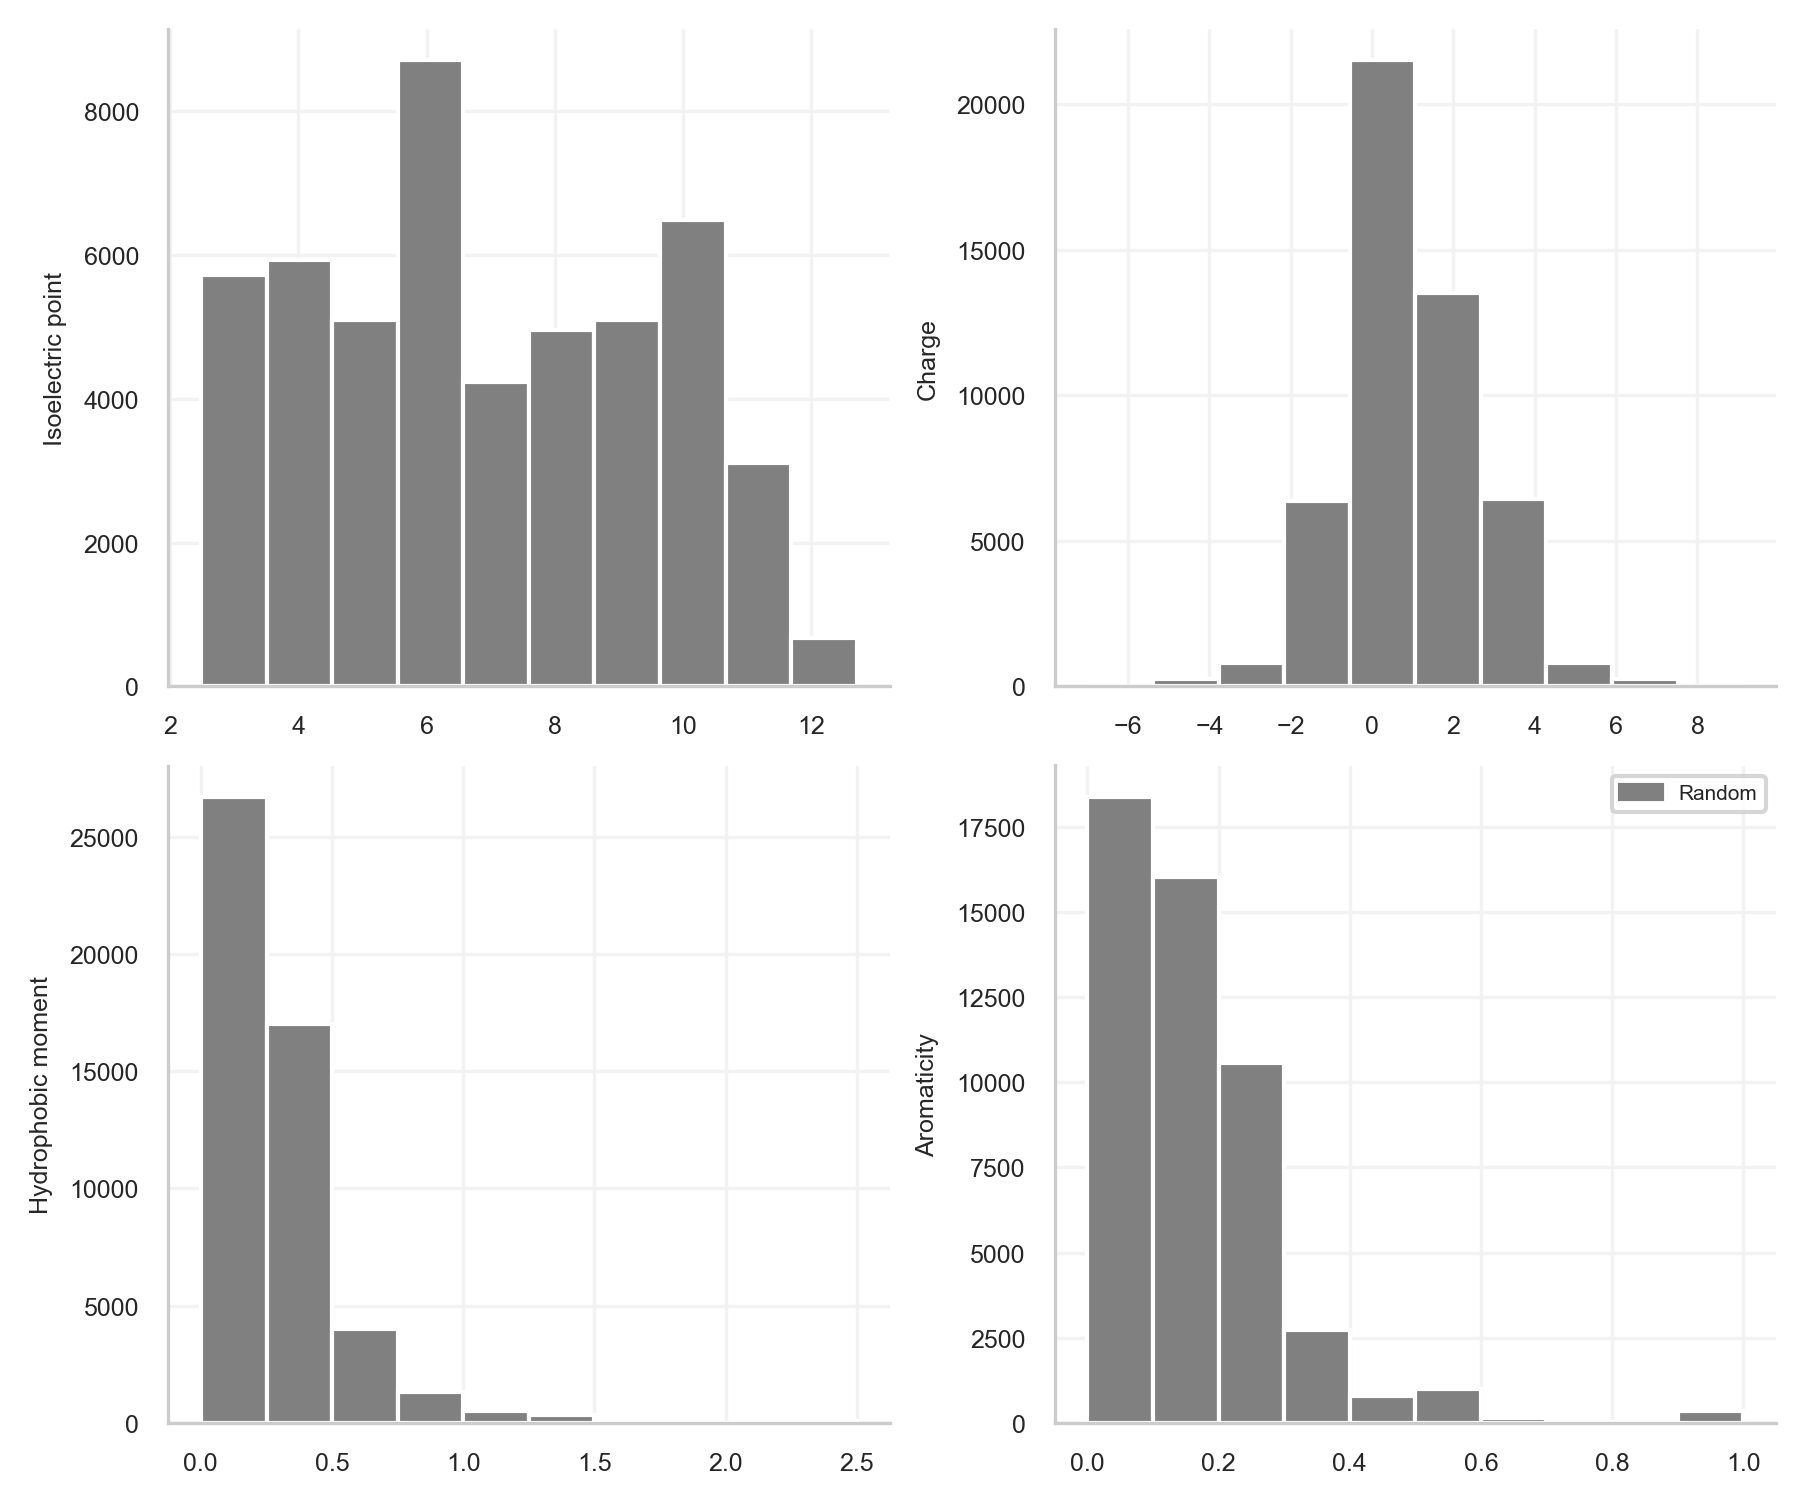

In [72]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['grey'], label=['Random']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    

    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

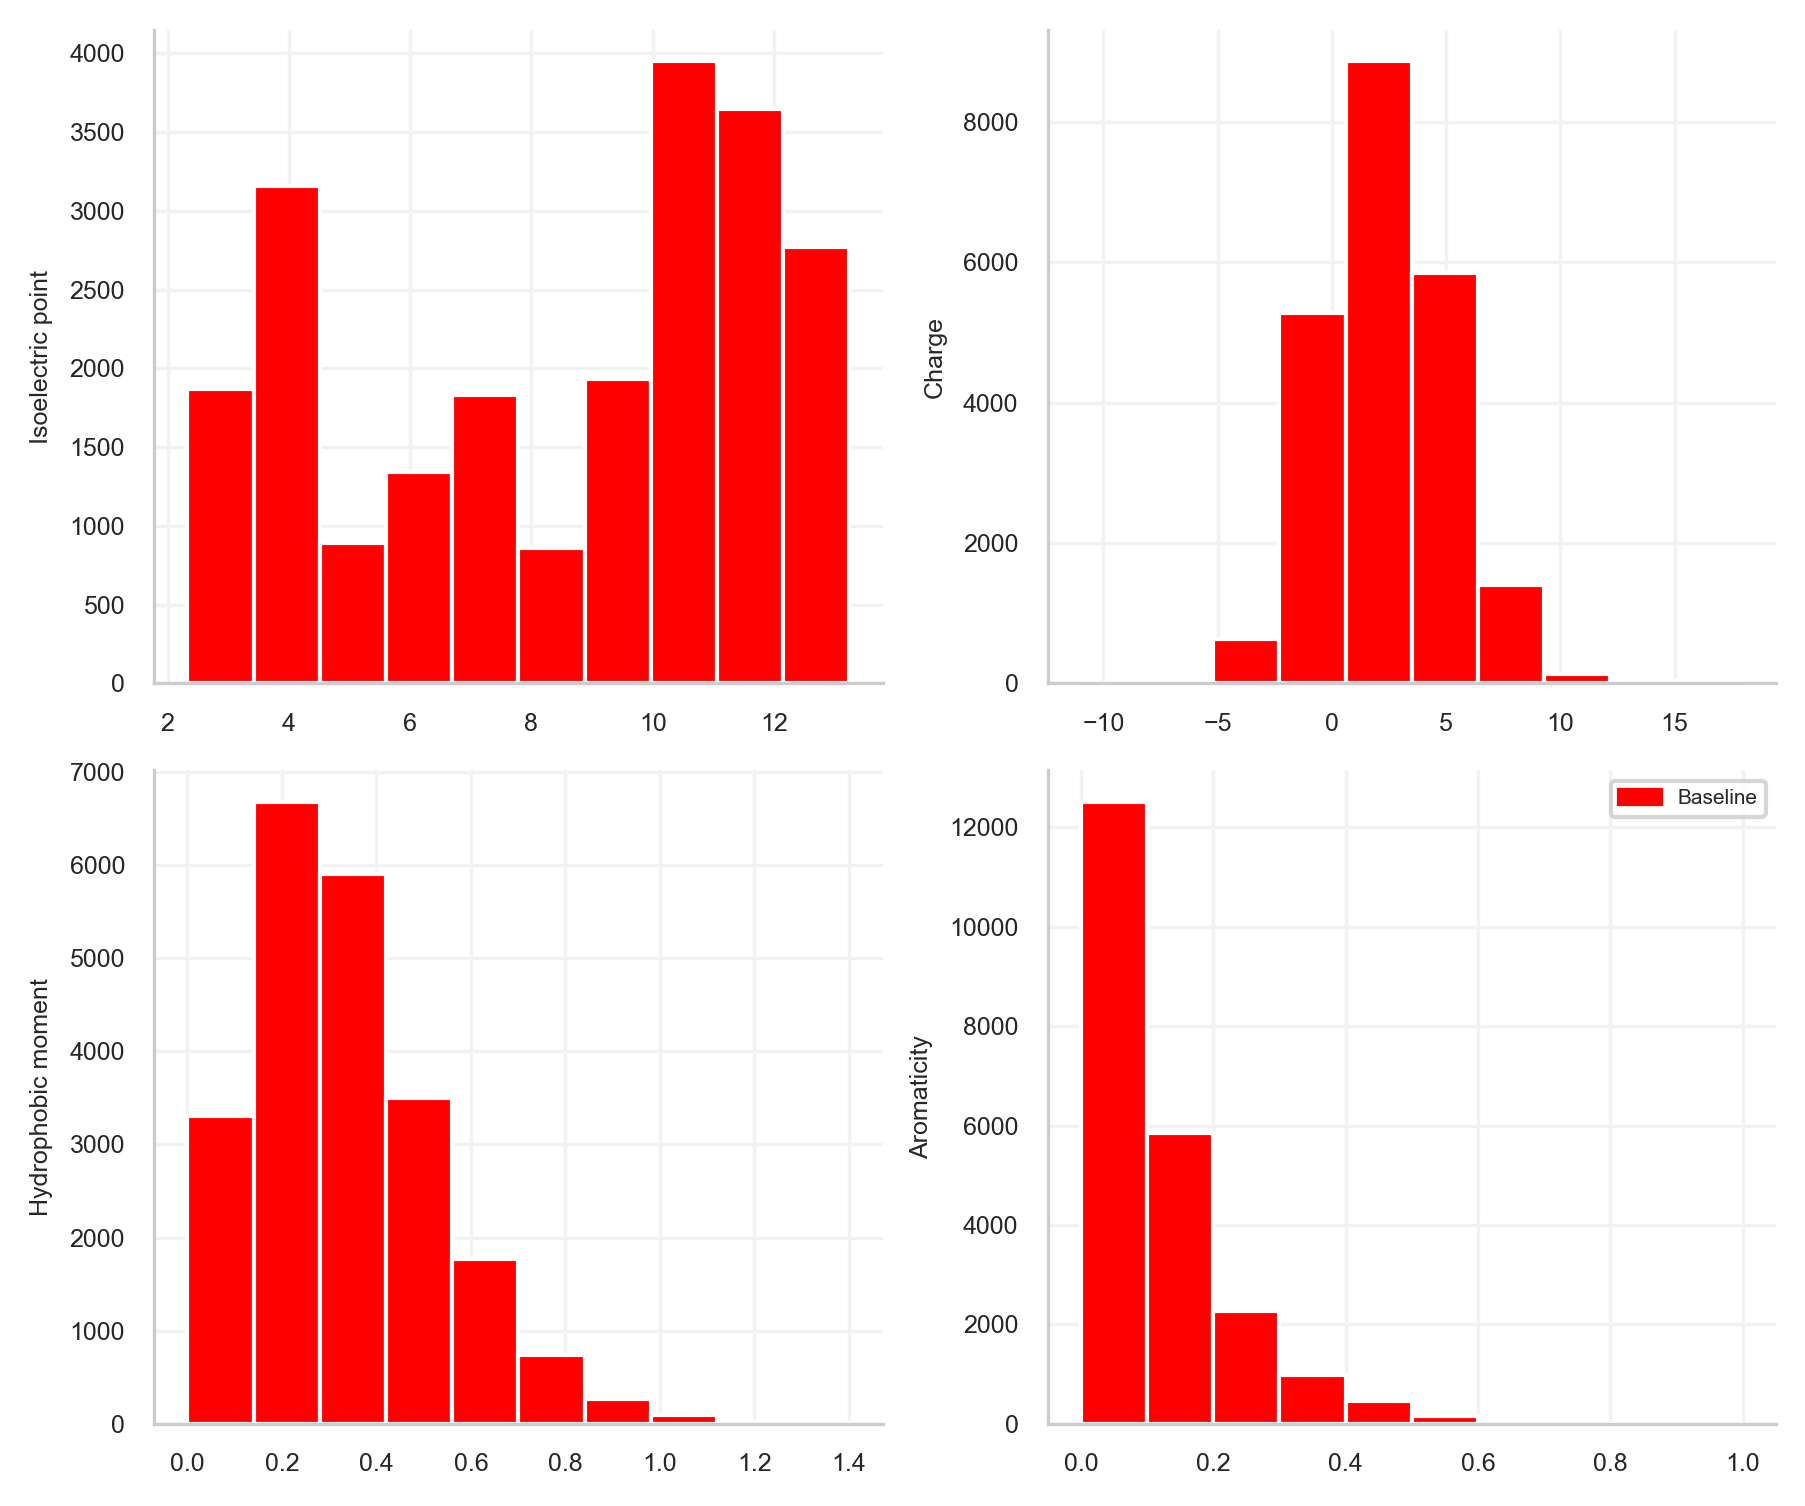

In [71]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Baseline']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['red'], label=['Baseline']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='red', label='Baseline'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

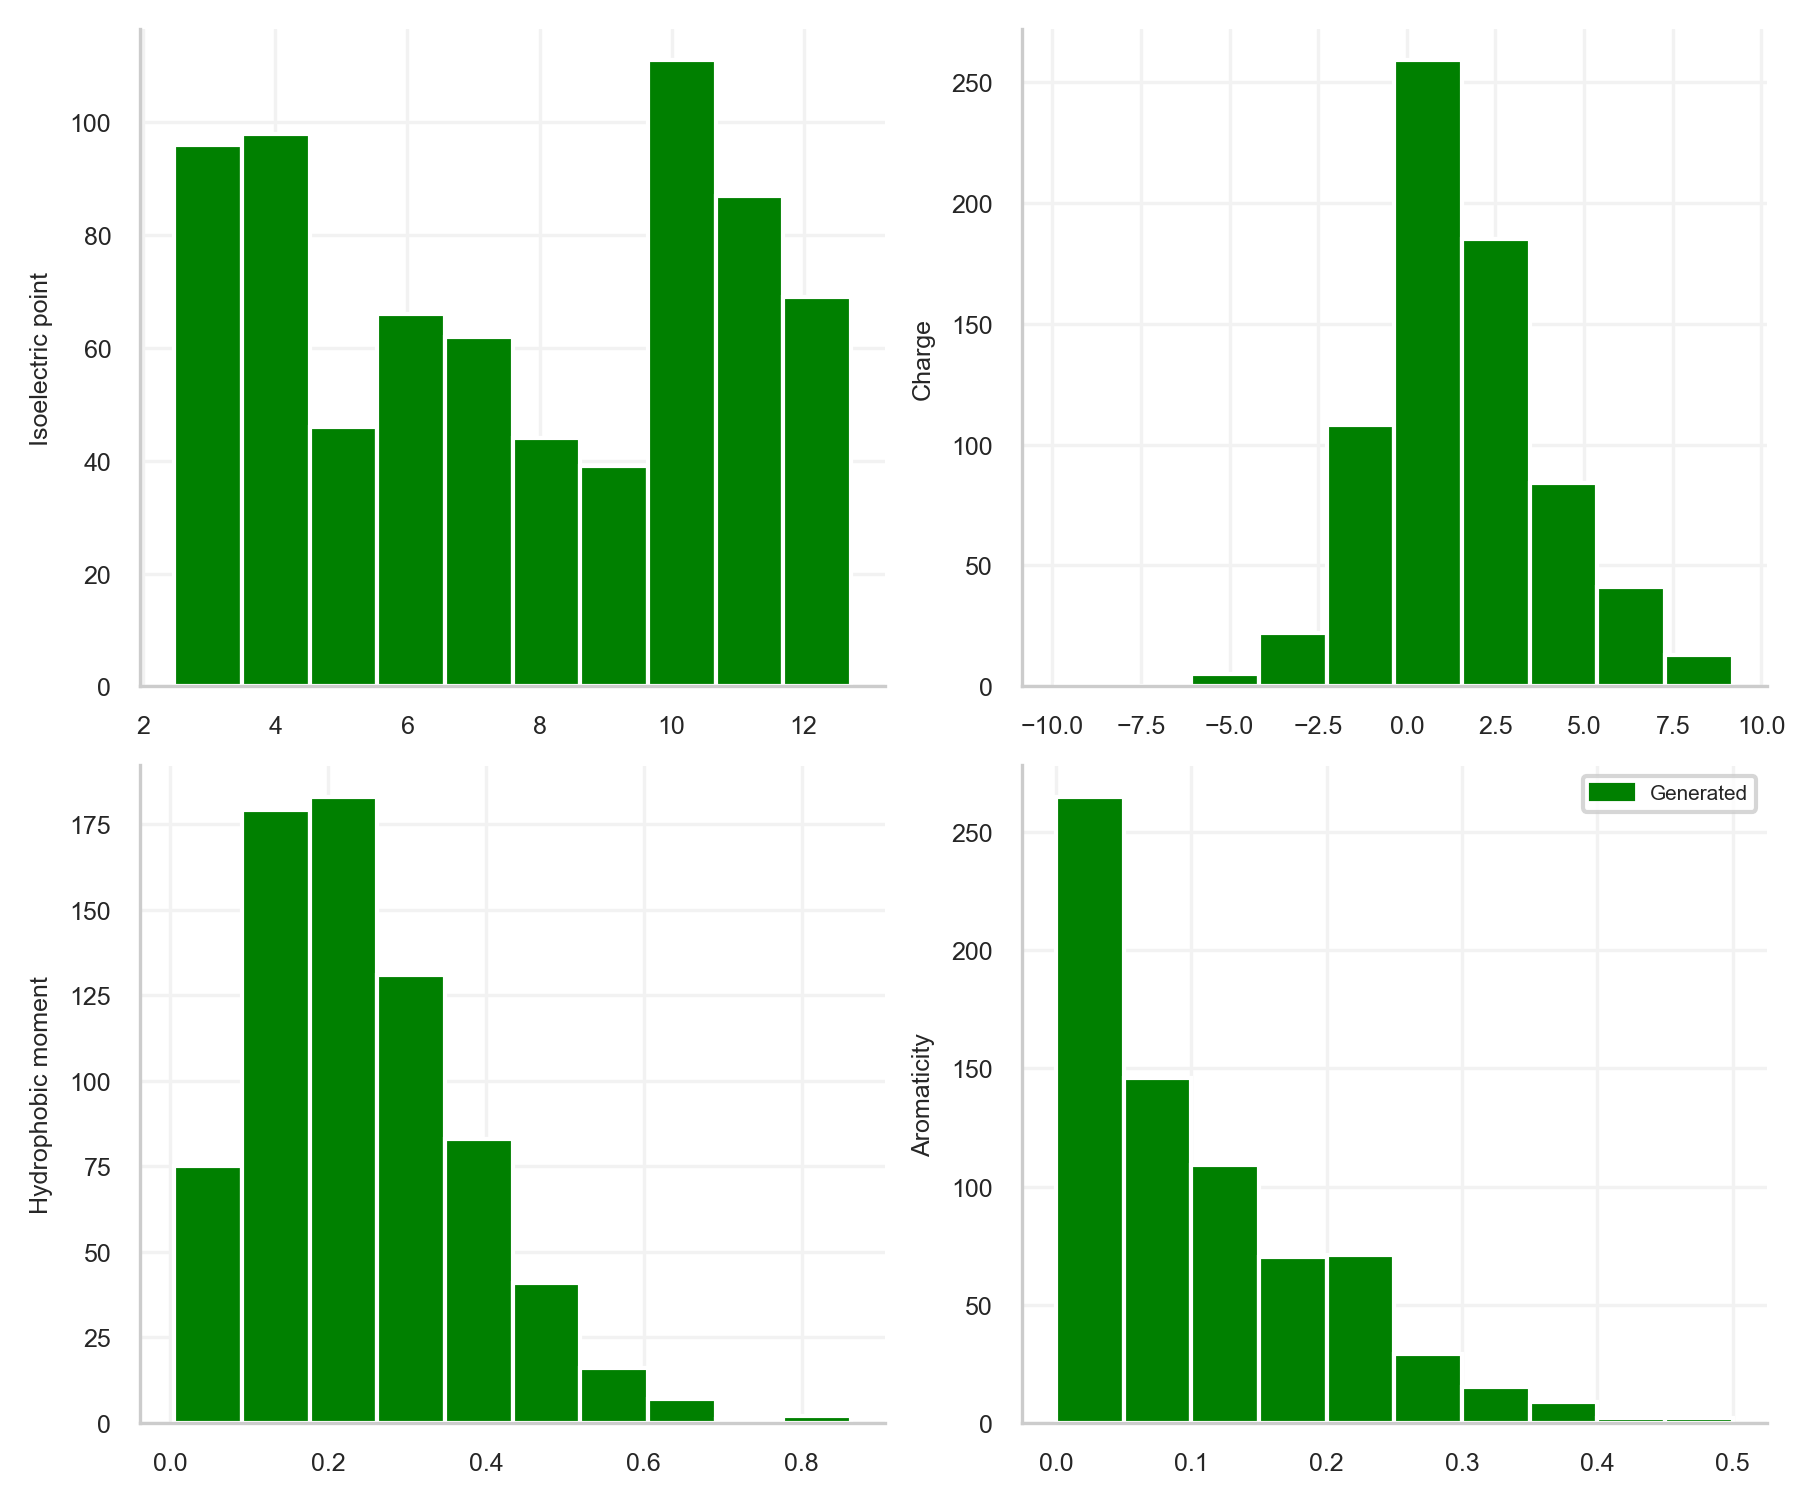

In [70]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['green'], label=['Generated']
    )
    
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

## Histograms

In [26]:
from decimal import getcontext
STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
loop = [STD_AA[i:i+1][0] for i in range(0, len(STD_AA), 1)]
getcontext().prec = 3

freq_generated_arvae = {}
freq_baseline = {}
freq_generated_iwae = {}

# all_amino_uniprot = sum(len(s) for s in uniprot_peptides)
all_amino_baseline = sum(len(s) for s in baseline_peptides)
all_amino_generated_arvae = sum(len(s) for s in generated_arvae)
all_amino_generated_iwae = sum(len(s) for s in generated_iwae)
for amino in loop:
    freq_generated_arvae[amino] = sum(s.count(amino) for s in generated_arvae)/all_amino_generated_arvae
    freq_baseline[amino] = sum(s.count(amino) for s in baseline_peptides)/all_amino_baseline
    freq_generated_iwae[amino] = sum(s.count(amino) for s in generated_iwae)/all_amino_generated_iwae

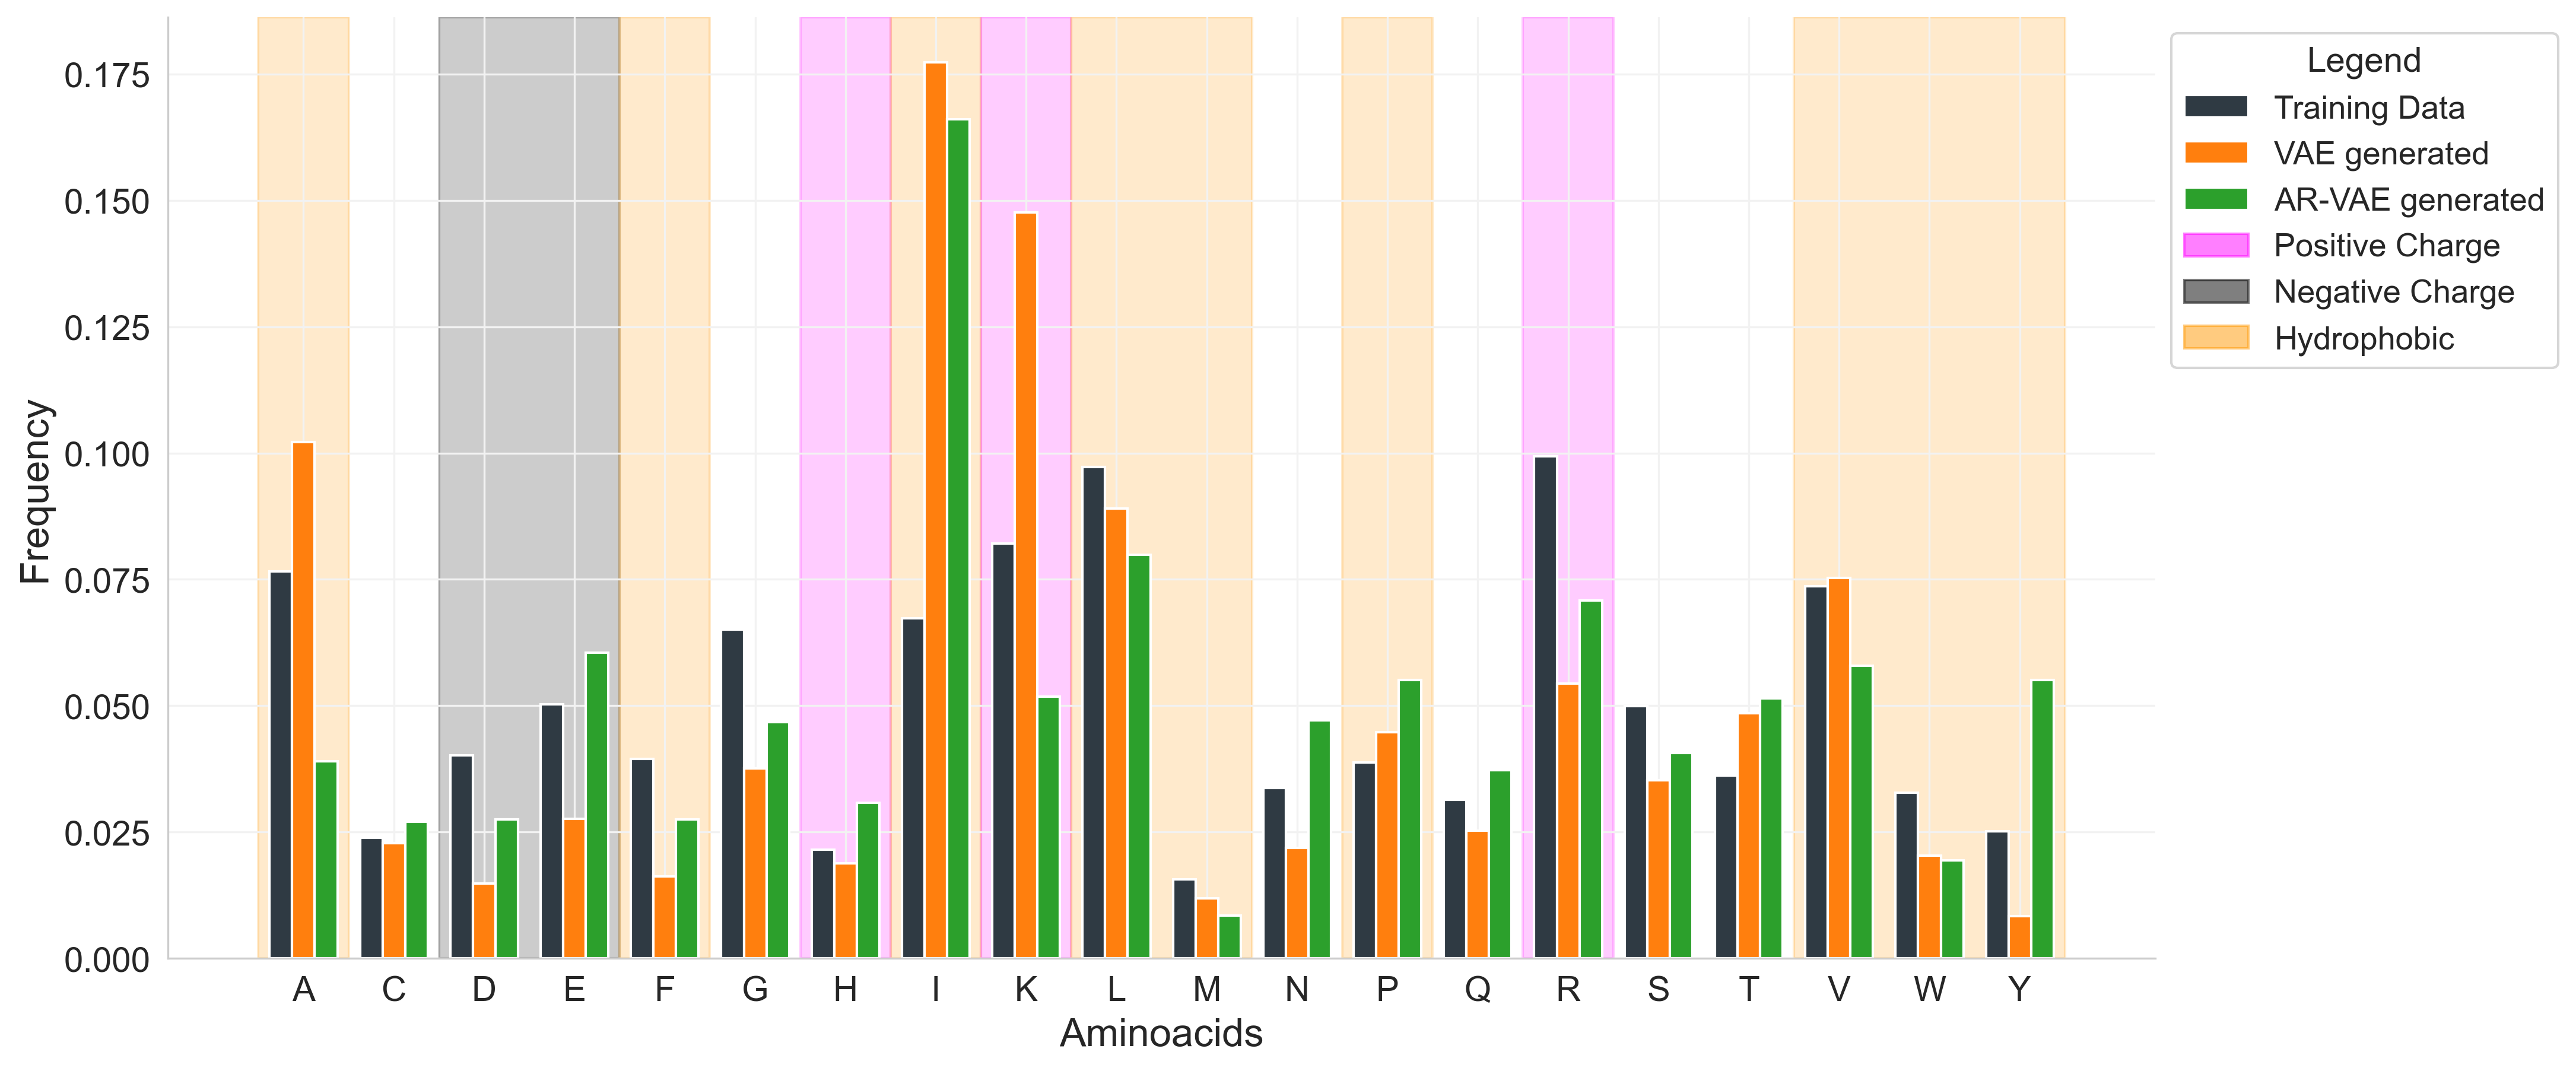

In [34]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import groupby
from operator import itemgetter

# --- Tworzenie symulowanych danych ---
all_possible_aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                    'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
# freq_baseline = {aa: np.random.rand() for aa in all_possible_aas}
# freq_generated_iwae = {aa: np.random.rand() for aa in all_possible_aas}
# freq_generated_arvae = {aa: np.random.rand() for aa in all_possible_aas}

fig, ax = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(17, 6),
    dpi=300,
)
datasets = [freq_baseline, freq_generated_iwae, freq_generated_arvae ]
all_keys = sorted(list(set(key for d in datasets for key in d.keys())))
selected_datasets = ['Training Data', 'VAE generated', 'AR-VAE generated']
x = np.arange(len(all_keys))
bar_colors = ["#2f3a43", '#ff7f0e', '#2ca02c'] 
for i, (data, name) in enumerate(zip(datasets,selected_datasets)):
    values = [data.get(key, 0) for key in all_keys]
    ax.bar(x + i * 0.25, values, width=0.25, label=name, color=bar_colors[i])

ax.set_xticks(x + 0.25 * (len(datasets) - 1) / 2)
ax.set_xticklabels(all_keys)

aa_with_positive_charge = ['K', 'R', 'H']
aa_with_negative_charge = ['D', 'E']
aa_hydrophobic = ['A', 'V', 'F', 'P', 'I', 'L', 'M', 'W', 'Y']
group_colors = {
    'Positive Charge': '#ff00ff', 
    'Negative Charge': '#000000',     
    'Hydrophobic': '#ff9900'      
}
aa_to_group = {}
for aa in all_possible_aas:
    if aa in aa_with_positive_charge:
        aa_to_group[aa] = 'Positive Charge'
    elif aa in aa_with_negative_charge:
        aa_to_group[aa] = 'Negative Charge'
    elif aa in aa_hydrophobic:
        aa_to_group[aa] = 'Hydrophobic'
idx_to_group_name = [aa_to_group.get(aa, 'None') for aa in all_keys]

# --- Poprawiona logika rysowania axvspan, wyśrodkowana na słupkach ---
groups = groupby(enumerate(idx_to_group_name), key=itemgetter(1))

for group_name, group_iter in groups:
    if group_name in group_colors and group_name != 'None':
        indices = [item[0] for item in group_iter]
        
        start_idx = indices[0]
        end_idx = indices[-1]

        # Przesunięcie o 0.25, aby wycentrować na grupie słupków
        offset = 0.25 * (len(datasets) - 1) / 2
        
        ax.axvspan(start_idx - 0.5 + offset, end_idx + 0.5 + offset,
            color=group_colors.get(group_name), alpha=0.2, zorder=0)


# --- Formatowanie osi Y ---
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('Aminoacids', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

# Dodaj legendę
handles, labels = ax.get_legend_handles_labels()
group_legend_patches = []
for group_name, color in group_colors.items():
    group_legend_patches.append(mpatches.Patch(color=color, label=group_name, alpha=0.5))

combined_handles = handles + group_legend_patches

ax.legend(
    handles=combined_handles,
    title="Legend",
    fontsize=13, 
    title_fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)
ax.tick_params(axis='x', labelsize=14) 
ax.tick_params(axis='y', labelsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save & Show Plot
fig.savefig("./aminoacid_acc.png")
# fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

## AR-VAE